# 房价预测案例

## 检视源数据集

In [6]:
import numpy as np
import pandas as pd
train_df = pd.read_csv('dataset/train.csv', index_col=0)
test_df = pd.read_csv('dataset/test.csv', index_col=0)
print(train_df.head())
print(train_df.info)
print(train_df.shape)

    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ... 

## 合并数据

### 拿出Price作为Label

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

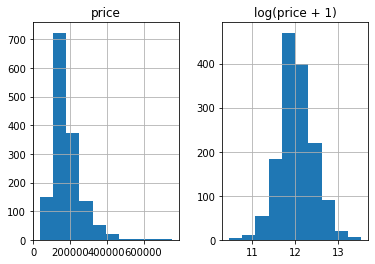

In [7]:
%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

In [8]:
y_train = np.log1p(train_df.pop('SalePrice'))
all_df = pd.concat((train_df, test_df), axis=0) # 合并训练、测试集
print(all_df.shape)
print(y_train.head())

(2919, 79)
Id
1    12.247699
2    12.109016
3    12.317171
4    11.849405
5    12.429220
Name: SalePrice, dtype: float64


## 变量转化

### MSSubClass

In [9]:
all_df['MSSubClass'].dtypes

dtype('int64')

In [10]:
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)  # from int to str
all_df['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

### 把category的变量转变成numerical表达形式

In [11]:
pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()  # 将分类数据转换为数值型数据
# 此刻MSSubClass被我们分成了12个column，每一个代表一个category。是就是1，不是就是0。

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [12]:
all_dummy_df = pd.get_dummies(all_df)  # 把所有的category数据都给 One-Hot了
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


### 处理好numerical变量

In [13]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10) # 将数据中有缺失项的属性统计出来并从大到小排序

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
BsmtUnfSF         1
GarageArea        1
TotalBsmtSF       1
GarageCars        1
BsmtFinSF2        1
dtype: int64

In [14]:
mean_cols = all_dummy_df.mean()  # 得到所有列的平均值
mean_cols.head(10)   # 打印出前10列数据的平均值
all_dummy_df = all_dummy_df.fillna(mean_cols) # 用每一列的平均值填充每一列中的NAN项
all_dummy_df.isnull().sum().sum()  # 检查是否还有 NAN 值

0

### 标准化numerical数据

In [15]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']  # 哪些是numerical的
print(numeric_cols)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [16]:
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()  # 算出每一个数值型的属性下数据的平均值
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()  # 算出每一个数值型的属性下数据的方差
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std  # 计算标准分布

## 建立模型

### 把数据集分回 训练/测试集

In [19]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]
print(dummy_train_df.shape)
print(dummy_test_df.shape)

(1460, 303)
(1459, 303)


### Ridge Regression

In [21]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
X_train = dummy_train_df.values
X_test = dummy_test_df.values

#### Cross Validation

In [22]:
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

#### 调参
存下所有的CV值，看看哪个alpha值更好

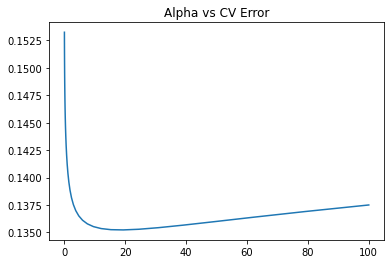

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error");

可见，大概alpha=10~20的时候，可以把score达到0.135左右。

### Random Forest

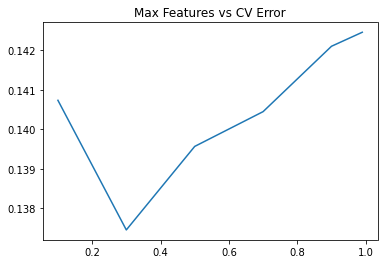

In [24]:
from sklearn.ensemble import RandomForestRegressor
max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error");

用RF的最优值达到了0.137

## Ensemble

用一个Stacking的思维来汲取两种或者多种模型的优点
首先，把最好的parameter拿出来，做成我们最终的model

In [25]:
ridge = Ridge(alpha=15)
rf = RandomForestRegressor(n_estimators=500, max_features=.3)

In [26]:
ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.3, n_estimators=500)

In [27]:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

RandomForestRegressor(max_features=0.3, n_estimators=500, n_jobs=1)

上面提到了，因为最前面我们给label做了个log(1+x), 于是这里我们需要把predit的值给exp回去，并且减掉那个"1"
所以就是我们的expm1()函数。

In [28]:
y_ridge = np.expm1(ridge.predict(X_test))
y_rf = np.expm1(rf.predict(X_test))

一个正经的Ensemble是把这群model的预测结果作为新的input，再做一次预测。这里我们简单的方法，就是直接『平均化』。

In [29]:
y_final = (y_ridge + y_rf) / 2  #对模型进行融合

## 提交结果

In [30]:
submission_df = pd.DataFrame(data= {'Id' : test_df.index, 'SalePrice': y_final})  
submission_df.head(10)

,Id,SalePrice
0,1461,119378.064359
1,1462,150914.669549
2,1463,174119.977609
3,1464,189508.217262
4,1465,195457.500240
5,1466,175308.610326
6,1467,176676.976667
7,1468,168842.566957
8,1469,184412.497796
9,1470,122920.799816
